In [1]:
#Removing Warnings
import warnings
warnings.filterwarnings('ignore')

## My Project Overview

We're using a mix of Python libraries to handle data, visualize patterns, reduce complexity, and build predictive models:

- **Pandas & NumPy**: For data manipulation and numerical operations.
- **Matplotlib & Seaborn**: To create charts and graphs for data insights.
- **PCA & StandardScaler**: To simplify data without losing essence.
- **KMeans & Silhouette Analysis**: For grouping similar data points and evaluating cluster quality.
- **Model Training & Metrics**: Splitting data, building a RandomForest model, and measuring its accuracy with various metrics.

Each tool is selected to ensure our data is clean, our insights are clear, and our predictions are accurate.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)

<h1 align = 'center'> DATA PREPROCESSING </h1>

In [3]:
dataset=pd.read_csv("data.csv")
labelset = pd.read_csv("labels.csv")

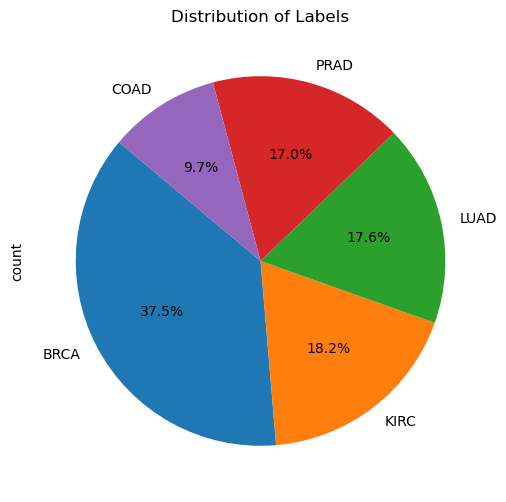


Number of columns with missing values: 0

Class Distribution:
Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5 MB

Labelset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [4]:
# Drop unnamed columns from the dataset
dataset.drop(dataset.filter(regex="Unnamed").columns, axis=1, inplace=True)

# Basic statistics for the dataset
# dataset_stats = dataset.apply(calculate_stats)

# Number of columns with missing values
num_columns_with_missing_values = dataset.isnull().any().sum()

# Visualization: Pie chart for class distribution
labelset['Class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, figsize=(6, 6))
plt.title('Distribution of Labels')
plt.show()

# Class distribution
class_distribution = labelset['Class'].value_counts()

# Print outputs
print("\nNumber of columns with missing values:", num_columns_with_missing_values)
print("\nClass Distribution:")
print(class_distribution)
print("\nDataset Information:")
dataset.info()
print("\nLabelset Information:")
labelset.info()

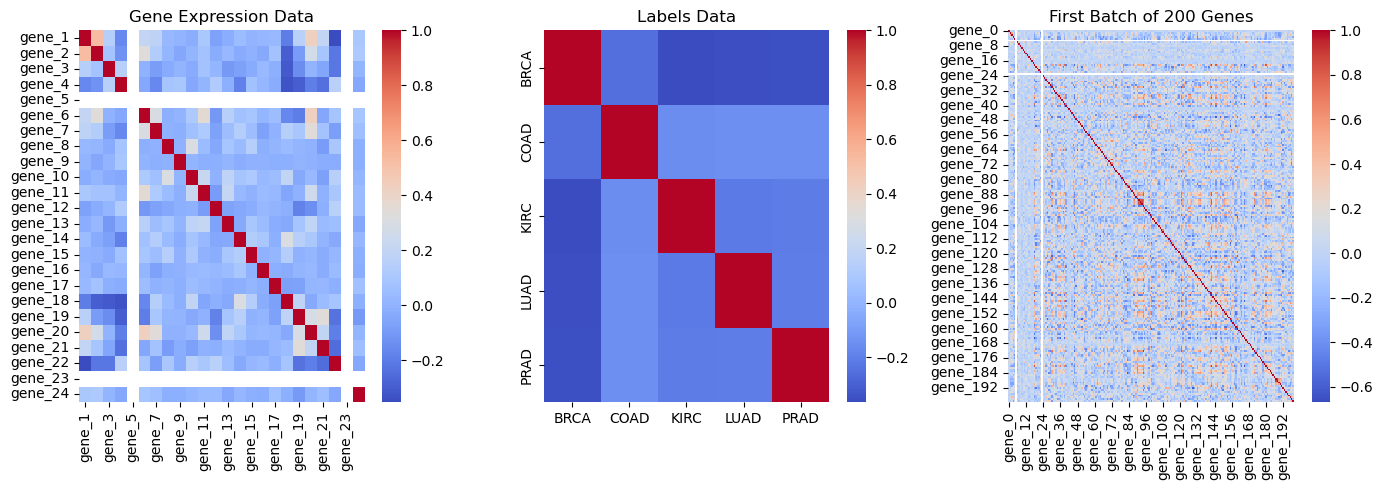

In [5]:
# Function to plot a heatmap for a given correlation matrix
def plot_heatmap(correlation_matrix, title, ax):
    sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax)
    ax.set_title(title)

# Generate correlation matrices
gene_correlation = dataset.iloc[:, 1:25].corr()
labels_encoded = pd.get_dummies(labelset['Class'])
labels_correlation = labels_encoded.corr()
batch_correlation = dataset.iloc[:, :200].corr()

# Create a figure with subplots for each heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Plot each heatmap
plot_heatmap(gene_correlation, 'Gene Expression Data', axes[0])
plot_heatmap(labels_correlation, 'Labels Data', axes[1])
plot_heatmap(batch_correlation, 'First Batch of 200 Genes', axes[2])

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


<h1 align = 'center'>NORMALIZATION AND MODEL SELECTION</h1>

In [6]:
#Using StandardScalar module for Normalization
X = dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.19479935, -0.82802988,  0.15980044, ..., -1.18793812,
        -0.11648251, -0.26190144],
       [-0.19479935, -2.01501735, -1.415042  , ..., -0.34227662,
        -1.65688871, -0.26190144],
       [-0.19479935,  0.41734754,  1.15673547, ...,  0.88686027,
        -1.85526414, -0.26190144],
       ...,
       [-0.19479935,  0.19888076,  0.57481583, ..., -0.22008186,
        -0.41046699,  1.3485582 ],
       [-0.19479935, -0.35045311, -0.28863152, ...,  1.43719268,
         0.09195083, -0.26190144],
       [-0.19479935, -0.57135218,  0.66725377, ...,  0.45087581,
        -0.47161901, -0.26190144]])

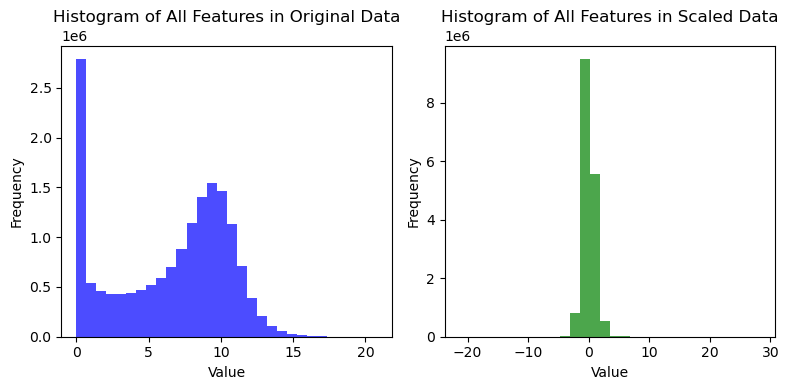

In [7]:
# Flatten the data to 1D arrays for histogram plotting
original_flat = X.to_numpy().flatten()
scaled_flat = X_scaled.flatten()

# Set up the matplotlib figure
plt.figure(figsize=(8, 4))

# Plot histograms for the original and scaled data
for i, data in enumerate([(original_flat, 'blue', 'Original Data'), (scaled_flat, 'green', 'Scaled Data')], 1):
    plt.subplot(1, 2, i)
    plt.hist(data[0], bins=30, color=data[1], alpha=0.7)
    plt.title(f'Histogram of All Features in {data[2]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


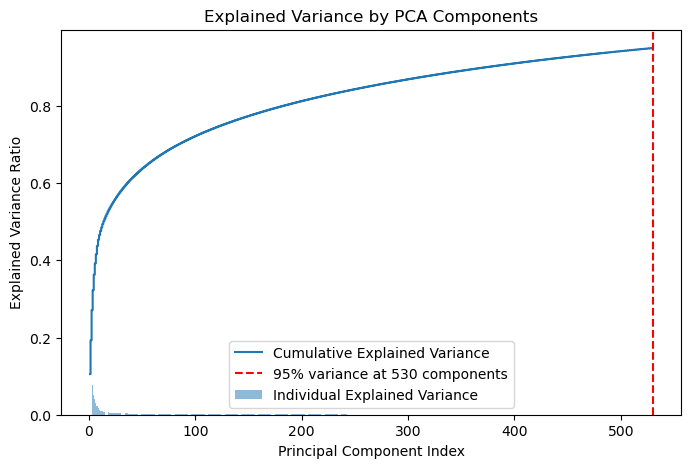

Number of components to retain 95% variance: 530
Original Number of Features (801, 20531)
Reduced Number of Features after PCA Reduction (801, 530)


In [8]:
# Perform PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Plotting the explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual Explained Variance')
plt.step(range(1, len(pca.explained_variance_ratio_.cumsum()) + 1), pca.explained_variance_ratio_.cumsum(), where='mid', label='Cumulative Explained Variance')
plt.axvline(x=pca.n_components_, color='r', linestyle='--', label=f'95% variance at {pca.n_components_} components')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

# Print the number of components
print(f"Number of components to retain 95% variance: {pca.n_components_}")

#Print the comparision of number of Feature reduces through PCA
print("=============================================\nOriginal Number of Features",X.shape)
print("Reduced Number of Features after PCA Reduction",X_pca.shape)


Explained variance ratio for each component: [0.10539781 0.08754232]
Number of components selected: 2
Shape of the PCA-transformed data: (801, 2)


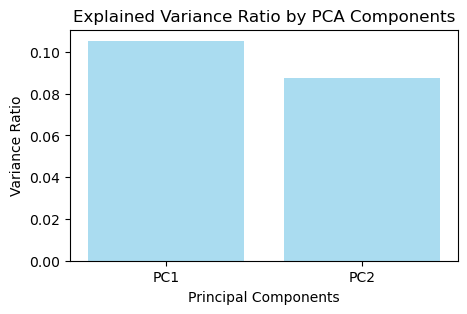

In [9]:
# Conduct PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Display the results
print(f"Explained variance ratio for each component: {pca.explained_variance_ratio_}")
print(f"Number of components selected: {pca.n_components_}")
print(f"Shape of the PCA-transformed data: {X_pca.shape}")

plt.figure(figsize=(5, 3
                   ))
plt.bar(['PC1', 'PC2'], pca.explained_variance_ratio_, color='skyblue', alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio by PCA Components')
plt.show()


In [10]:
# Load the target label data
df = pd.read_csv("labels.csv")

# Perform PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Concatenate the principal components with the target label data
finalDf = pd.concat([principalDf, df[['Class']]], axis=1)

# Display the final DataFrame
finalDf

,PC1,PC2,Class
0,-57.446987,95.410981,PRAD
1,-16.919430,0.732470,LUAD
2,-70.345218,-19.303327,PRAD
3,-49.161591,-9.227586,PRAD
4,-18.132534,-51.327797,BRCA
...,...,...,...
796,-12.417385,-42.321574,BRCA
797,-29.415554,28.526281,LUAD
798,-4.133089,15.690014,COAD
799,-30.814757,33.526423,PRAD


In [11]:
# Perform PCA for 3 components and create a DataFrame with the results
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_scaled)
principalDf2 = pd.DataFrame(principalComponents, columns=['PC1', 'PC2', 'PC3'])

# Concatenate the principal components with the class labels
finalDf2 = pd.concat([principalDf2, df[['Class']]], axis=1)

# Print the explained variance by the first 3 principal components
print(f"Explained variance by the first 3 principal components: {pca.explained_variance_ratio_} \n")

# Display the final DataFrame with principal components and class labels
finalDf2

Explained variance by the first 3 principal components: [0.10539781 0.08754232 0.07810081] 



,PC1,PC2,PC3,Class
0,-57.446987,95.410980,74.301543,PRAD
1,-16.919430,0.732471,-64.072899,LUAD
2,-70.345218,-19.303326,20.488241,PRAD
3,-49.161591,-9.227586,61.243770,PRAD
4,-18.132533,-51.327797,16.598116,BRCA
...,...,...,...,...
796,-12.417385,-42.321573,28.109566,BRCA
797,-29.415554,28.526281,-15.956631,LUAD
798,-4.133090,15.690013,-22.644455,COAD
799,-30.814757,33.526422,70.565636,PRAD


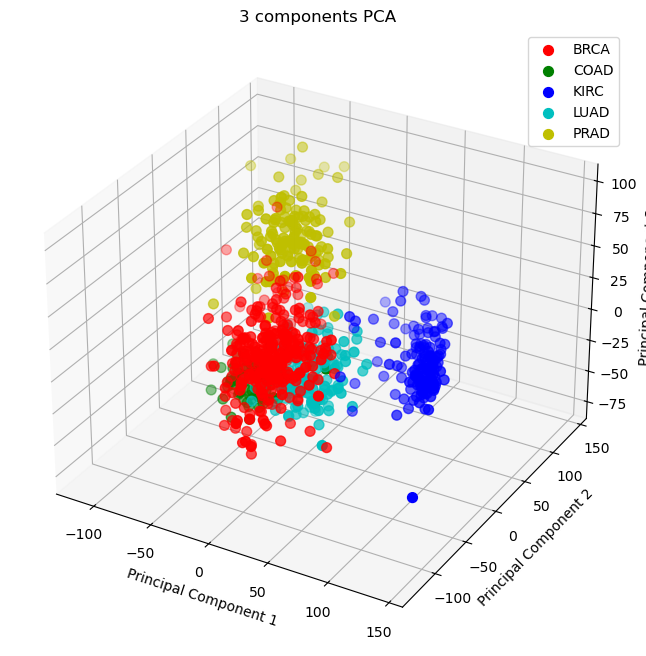

In [12]:
# Set up the figure for 3D plotting
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})

# Define the class labels and colors
targets_colors = [('BRCA', 'r'), ('COAD', 'g'), ('KIRC', 'b'), ('LUAD', 'c'), ('PRAD', 'y')]

# Plot each class in the 3D scatter plot
for target, color in targets_colors:
    indices = finalDf2['Class'] == target
    ax.scatter(finalDf2.loc[indices, 'PC1'], finalDf2.loc[indices, 'PC2'], finalDf2.loc[indices, 'PC3'], c=color, s=50)

# Labeling and title
ax.set(xlabel='Principal Component 1', ylabel='Principal Component 2', zlabel='Principal Component 3', title='3 components PCA')

# Legend and grid
ax.legend([target for target, _ in targets_colors])
plt.show()


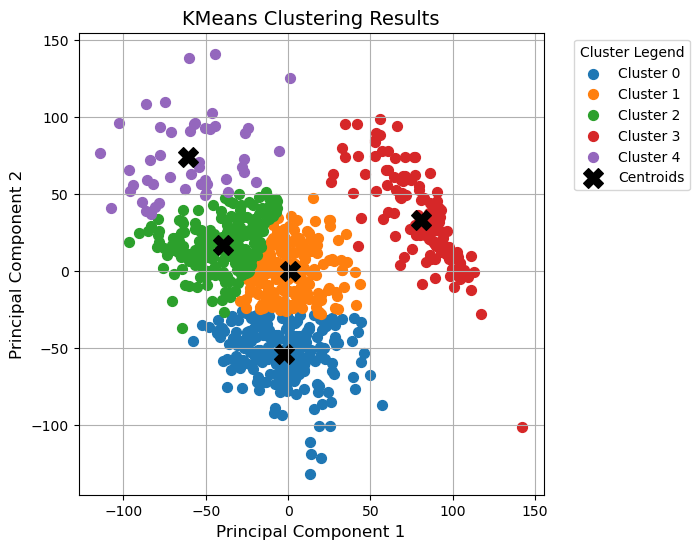

In [13]:
# Initialize KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, init="k-means++", n_init=50, max_iter=500, random_state=42)

# Fit the KMeans algorithm to the PCA-transformed data
kmeans.fit(X_pca)

# Retrieve the cluster labels
clusters = kmeans.labels_

# Set up the plot
plt.figure(figsize=(6, 6))

# Plot each cluster
for cluster in np.unique(clusters):
    # Create a mask for the cluster
    mask = clusters == cluster
    # Scatter plot for each cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=50, label=f"Cluster {cluster}", cmap='plasma')

# Plot the centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Centroids")

# Labeling the plot
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('KMeans Clustering Results', fontsize=14)

# Add a legend
plt.legend(title="Cluster Legend", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid and plot
plt.grid(True)
plt.show()


For n_clusters = 2, the average silhouette_score is : 0.4921565460390341


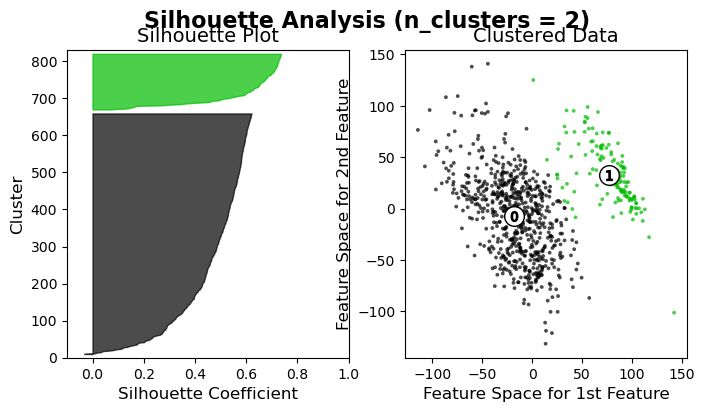

For n_clusters = 3, the average silhouette_score is : 0.46012465998699137


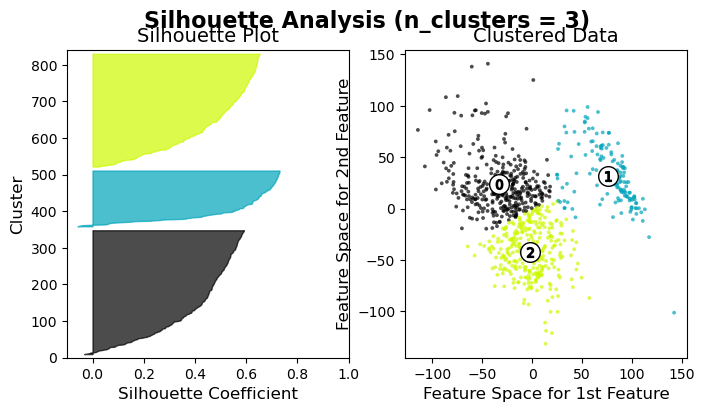

For n_clusters = 4, the average silhouette_score is : 0.40872053757504995


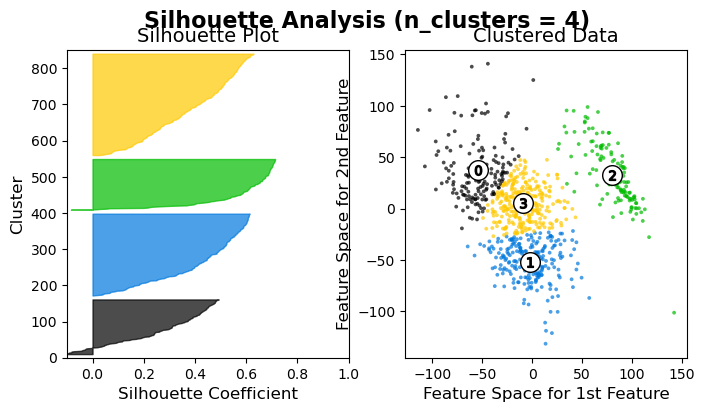

For n_clusters = 5, the average silhouette_score is : 0.38999278696864886


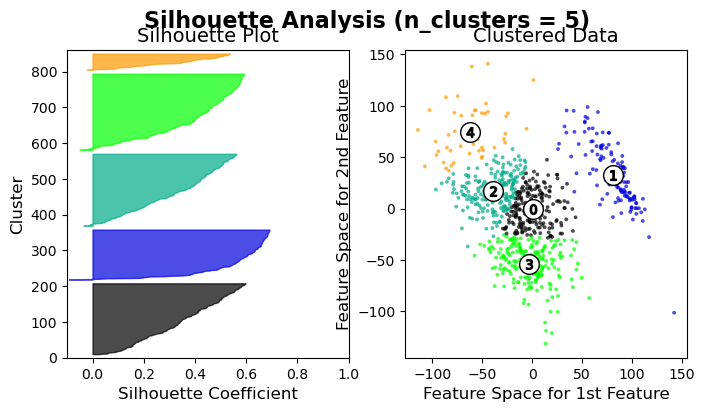

For n_clusters = 6, the average silhouette_score is : 0.3871093564473097


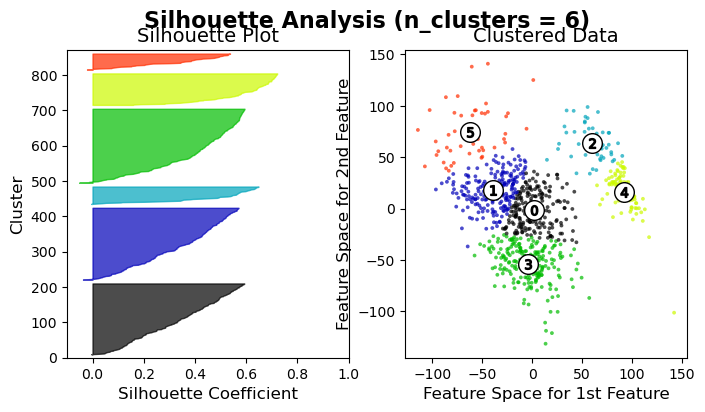

In [14]:
# Define the range of clusters to analyze
range_n_clusters = [2, 3, 4, 5, 6]

# Perform silhouette analysis for each cluster count
for n_clusters in range_n_clusters:
    # Initialize KMeans and compute cluster labels
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)
    
    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
    
    # Set up the figure for silhouette plot and clustered data visualization
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    
    # Silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])
    silhouette_values = silhouette_samples(X_pca, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Sort silhouette values and plot
        ith_values = np.sort(silhouette_values[cluster_labels == i])
        y_upper = y_lower + ith_values.shape[0]
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10
    
    # Clustered data visualization
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    # Plot cluster centers
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    # Enhance plot aesthetics
    ax1.set_title("Silhouette Plot", fontsize=14)
    ax1.set_xlabel("Silhouette Coefficient", fontsize=12)
    ax1.set_ylabel("Cluster", fontsize=12)
    ax2.set_title("Clustered Data", fontsize=14)
    ax2.set_xlabel("Feature Space for 1st Feature", fontsize=12)
    ax2.set_ylabel("Feature Space for 2nd Feature", fontsize=12)
    plt.suptitle(f"Silhouette Analysis (n_clusters = {n_clusters})", fontsize=16, fontweight='bold')
    
    plt.show()

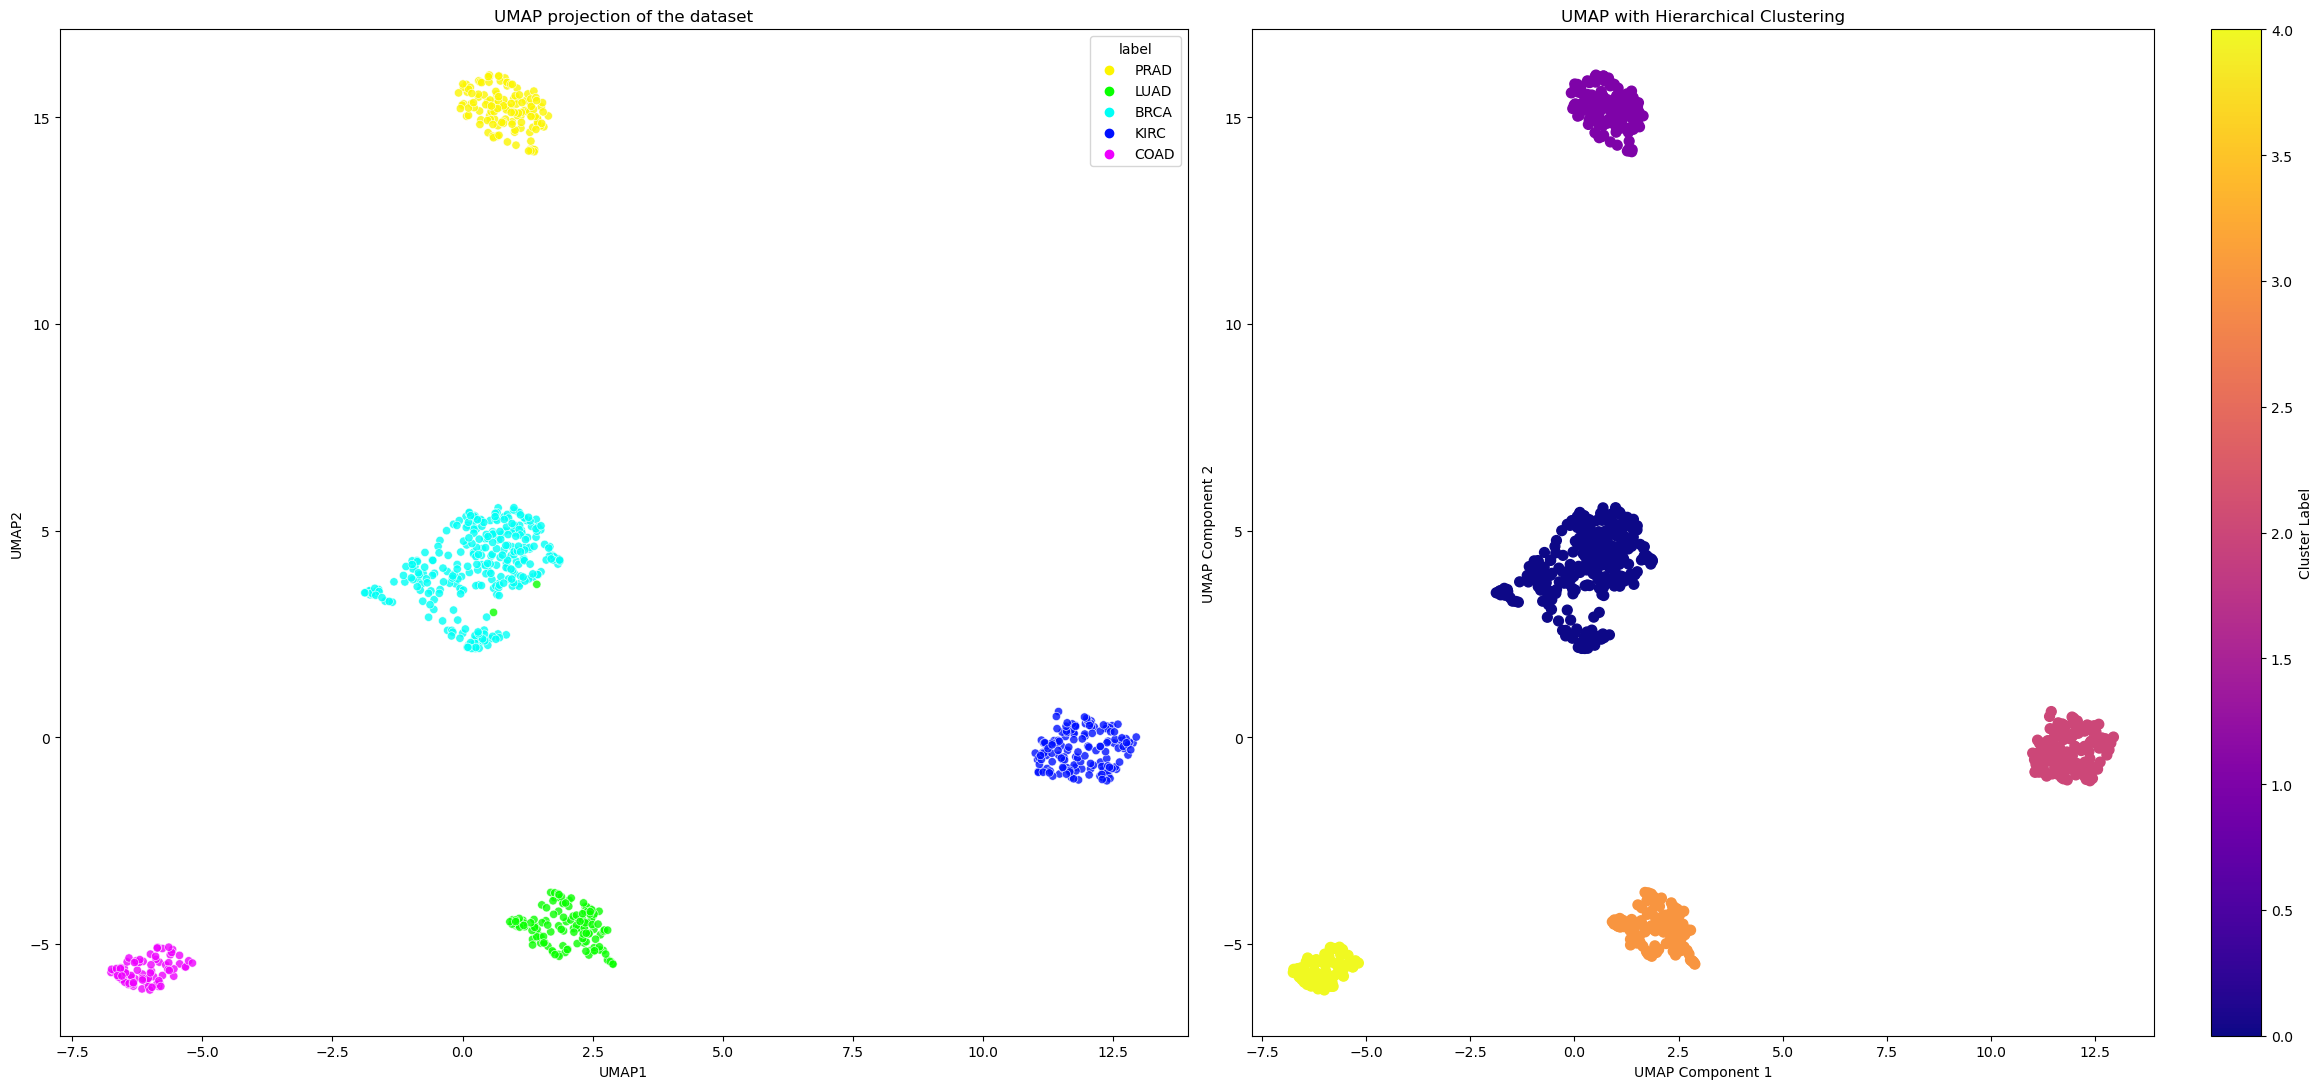

In [15]:
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Perform Hierarchical clustering on the reduced data
hierarchical_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
hierarchical_cluster.fit(X_umap)
hierarchical_labels = hierarchical_cluster.labels_

# Create a DataFrame for visualization
embedding_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
embedding_df['label'] = labelset['Class']
embedding_df['hierarchical_labels'] = hierarchical_labels

# Create subplots for side by side visualization
fig, axes = plt.subplots(1, 2, figsize=(24, 11))

# Plot UMAP results
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='label',
    palette=sns.color_palette("hsv", 5),
    data=embedding_df,
    legend="full",
    alpha=0.8,
    ax=axes[0]
)
axes[0].set_title('UMAP projection of the dataset')

# Plot UMAP results with Hierarchical clustering
scatter = axes[1].scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c=embedding_df['hierarchical_labels'], cmap='plasma', s=50)
axes[1].set_title('UMAP with Hierarchical Clustering')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
plt.colorbar(scatter, ax=axes[1], label='Cluster Label')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Davies-Bouldin Index: 0.16555471947730155


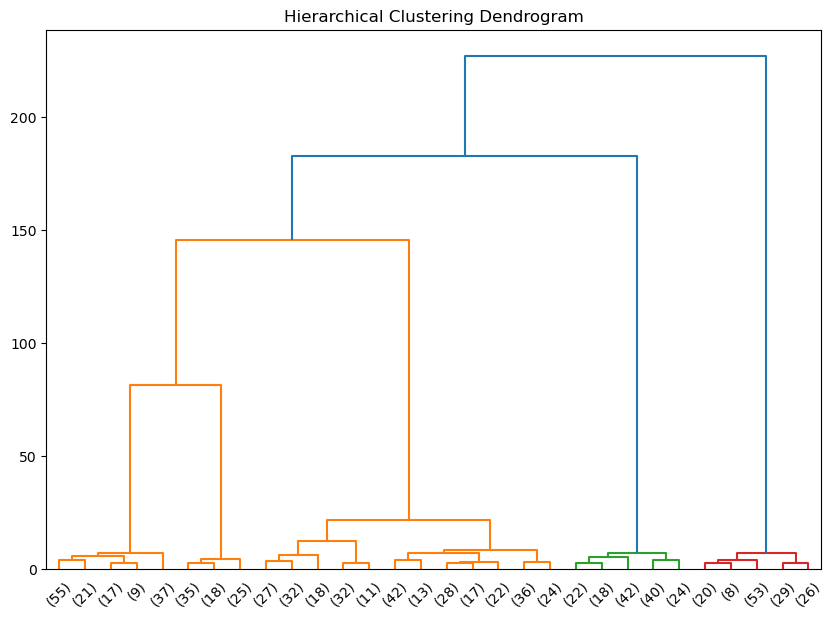

In [16]:
from sklearn.metrics import davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(X_umap, hierarchical_labels)
print(f"Davies-Bouldin Index: {db_index}")

# Visualization of Hierarchical Clustering Dendrogram
linked = linkage(X_umap, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, truncate_mode = "lastp")
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


<h1 align = 'center'>Models Training using PCA(Principal Component Analysis)</h1>

Principal Component Analysis (PCA) is a widely-used technique for dimensionality reduction. Here's a simplified overview:

- **Objective**: PCA aims to reduce the dimensionality of a dataset while preserving as much variance as possible. It achieves this by transforming the original features into a new set of orthogonal components called principal components.

- **Assumptions**: PCA assumes that the directions in which the data varies the most are the most informative and can be captured by the principal components.

- **Algorithm**: PCA calculates the principal components by finding the eigenvectors of the covariance matrix of the data. These eigenvectors represent the directions of maximum variance.

- **Selection of Components**: The number of principal components to retain is typically chosen based on the amount of variance explained by each component or by setting a threshold for cumulative variance explained.

- **Application**: PCA is used for various purposes, including data visualization, noise reduction, feature extraction, and speeding up machine learning algorithms by reducing the dimensionality of the input space.

- **Installation**: PCA is a part of the scikit-learn library in Python, so you can install it along with scikit-learn using pip:
- `pip install scikit-learn`
  
- **User Guide / Tutorial**: Scikit-learn provides comprehensive documentation and tutorials on how to use PCA effectively for dimensionality reduction and other tasks.

PCA is a fundamental tool in the arsenal of data scientists and machine learning practitioners for handling high-dimensional data and uncovering underlying patterns and structures.

In [17]:
X = dataset
Y = labelset['Class']

# Split the dataset into training and testing sets with a test size of 25%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Initialize PCA to retain 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the training data and transform both training and testing data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# The shapes of the transformed data can be printed to verify the reduction
print(f"Original training data shape: {X_train.shape}")
print(f"Transformed training data shape: {X_train_pca.shape}")
print(f"Original testing data shape: {X_test.shape}")
print(f"Transformed testing data shape: {X_test_pca.shape}")


Original training data shape: (600, 20531)
Transformed training data shape: (600, 373)
Original testing data shape: (201, 20531)
Transformed testing data shape: (201, 373)


Random Forest Metrics:
Accuracy: 98.01%
Precision (macro avg): 98.69%
Recall (macro avg): 96.55%
F1-score (macro avg): 97.51%

Classification Report:
              precision    recall  f1-score   support

        BRCA       0.96      1.00      0.98        80
        COAD       1.00      0.86      0.92        21
        KIRC       1.00      1.00      1.00        31
        LUAD       1.00      1.00      1.00        35
        PRAD       0.97      0.97      0.97        34

    accuracy                           0.98       201
   macro avg       0.99      0.97      0.98       201
weighted avg       0.98      0.98      0.98       201



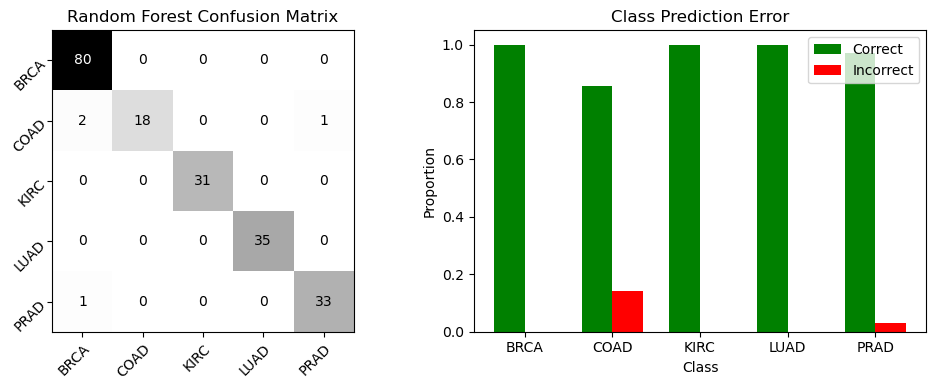

In [18]:
# Initialize the RandomForestClassifier with a random state for reproducibility for "PCA"
rfc_clf = RandomForestClassifier(random_state=42)

# Fit the classifier on the PCA-transformed training data
rfc_clf.fit(X_train_pca, y_train)

# Predict on the PCA-transformed testing data
y_pred = rfc_clf.predict(X_test_pca)

# Define target names for the classification report
target_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average="macro")
rf_recall = recall_score(y_test, y_pred, average="macro")
rf_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy*100:.2f}%")
print(f"Precision (macro avg): {rf_precision*100:.2f}%")
print(f"Recall (macro avg): {rf_recall*100:.2f}%")
print(f"F1-score (macro avg): {rf_fscore*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Gradient Boosting Metrics:
Accuracy: 98.51%
Precision (macro avg): 98.42%
Recall (macro avg): 97.51%
F1-score (macro avg): 97.88%

Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        80
        COAD       1.00      0.90      0.95        21
        KIRC       1.00      1.00      1.00        31
        LUAD       0.92      1.00      0.96        35
        PRAD       1.00      0.97      0.99        34

    accuracy                           0.99       201
   macro avg       0.98      0.98      0.98       201
weighted avg       0.99      0.99      0.99       201



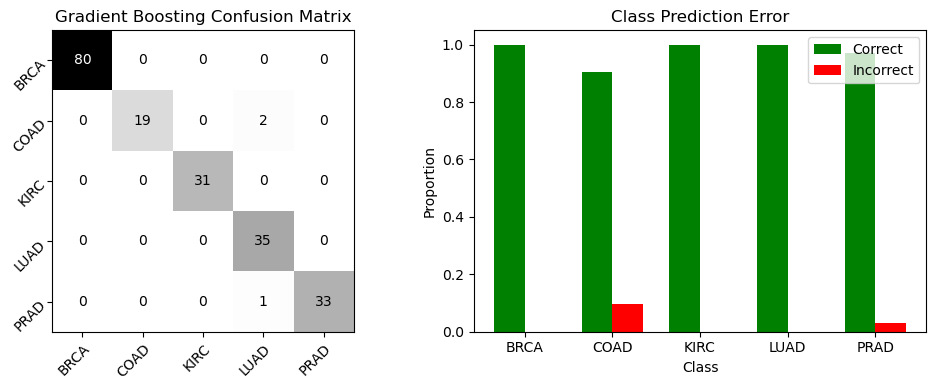

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier()

# Fit the model
gb_clf.fit(X_train_pca, y_train)
y_pred = gb_clf.predict(X_test_pca)

# Define target names for the classes
target_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Calculate metrics
gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred, average="macro")
gb_recall = recall_score(y_test, y_pred, average="macro")
gb_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"Gradient Boosting Metrics:")
print(f"Accuracy: {gb_accuracy*100:.2f}%")
print(f"Precision (macro avg): {gb_precision*100:.2f}%")
print(f"Recall (macro avg): {gb_recall*100:.2f}%")
print(f"F1-score (macro avg): {gb_fscore*100:.2f}%")

# Generate and display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('Gradient Boosting Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Neural Network Metrics:
Accuracy: 99.00%
Precision (macro avg): 99.51%
Recall (macro avg): 98.84%
F1-score (macro avg): 99.16%

Classification Report:
              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        80
        COAD       1.00      1.00      1.00        21
        KIRC       1.00      1.00      1.00        31
        LUAD       1.00      0.97      0.99        35
        PRAD       1.00      0.97      0.99        34

    accuracy                           0.99       201
   macro avg       1.00      0.99      0.99       201
weighted avg       0.99      0.99      0.99       201



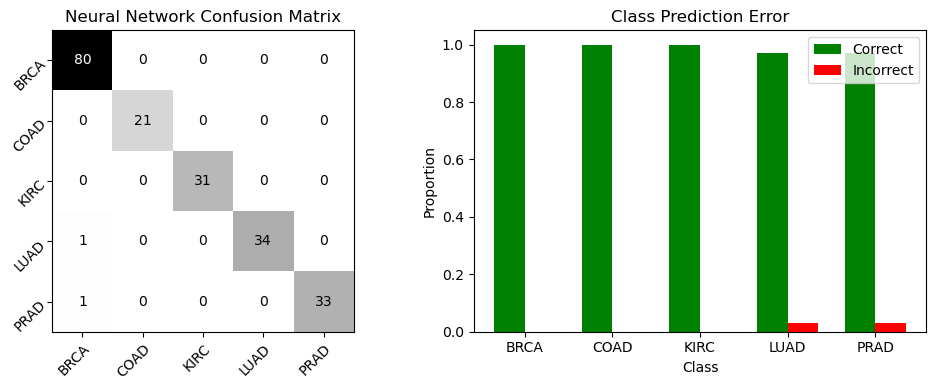

In [20]:
from sklearn.neural_network import MLPClassifier

# Initialize the Neural Network classifier with one hidden layer of 150 neurons
nn_clf = MLPClassifier(hidden_layer_sizes=(150,), max_iter=200, activation='relu', solver='adam', random_state=1)

# Train the model and predict on the test set
nn_clf.fit(X_train_pca, y_train)
y_pred = nn_clf.predict(X_test_pca)

# Define target names for the classes
target_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Calculate metrics
nn_accuracy = accuracy_score(y_test, y_pred)
nn_precision = precision_score(y_test, y_pred, average="macro")
nn_recall = recall_score(y_test, y_pred, average="macro")
nn_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"Neural Network Metrics:")
print(f"Accuracy: {nn_accuracy*100:.2f}%")
print(f"Precision (macro avg): {nn_precision*100:.2f}%")
print(f"Recall (macro avg): {nn_recall*100:.2f}%")
print(f"F1-score (macro avg): {nn_fscore*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('Neural Network Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

XGBoost Classifier Metrics:
Accuracy: 99.00%
Precision (macro avg): 98.92%
Recall (macro avg): 99.16%
F1-score (macro avg): 99.02%

Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      0.99      0.99        80
        COAD       1.00      1.00      1.00        21
        KIRC       1.00      1.00      1.00        31
        LUAD       0.95      1.00      0.97        35
        PRAD       1.00      0.97      0.99        34

    accuracy                           0.99       201
   macro avg       0.99      0.99      0.99       201
weighted avg       0.99      0.99      0.99       201



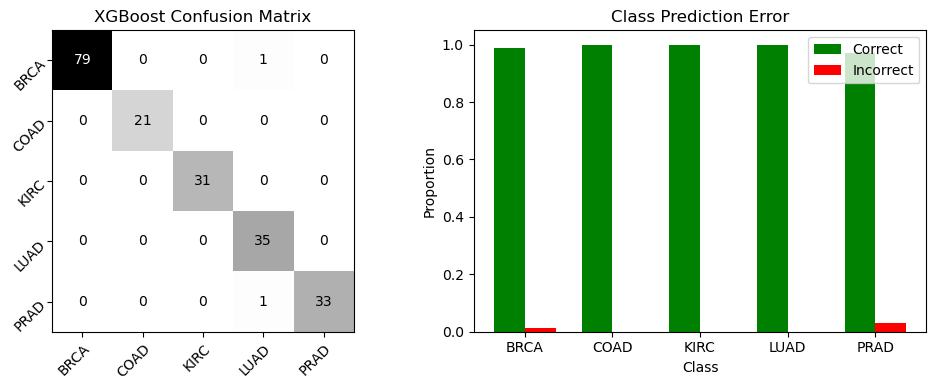

In [21]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Data preparation
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

# PCA transformation
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# XGBoost classifier for "PCA"
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=len(set(y_encoded)), seed=42)
xgb_clf.fit(X_train_pca, y_train)
y_pred = xgb_clf.predict(X_test_pca)

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred, average="macro")
xgb_recall = recall_score(y_test, y_pred, average="macro")
xgb_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"XGBoost Classifier Metrics:")
print(f"Accuracy: {xgb_accuracy*100:.2f}%")
print(f"Precision (macro avg): {xgb_precision*100:.2f}%")
print(f"Recall (macro avg): {xgb_recall*100:.2f}%")
print(f"F1-score (macro avg): {xgb_fscore*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('XGBoost Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

+-------------------+----------+-----------+--------+----------+
|    Classifier     | Accuracy | Precision | Recall | F1-Score |
+-------------------+----------+-----------+--------+----------+
|   Random Forest   |   0.98   |   0.987   | 0.966  |  0.975   |
| Gradient Boosting |  0.985   |   0.984   | 0.975  |  0.979   |
|  Neural Network   |   0.99   |   0.995   | 0.988  |  0.992   |
|      XGBoost      |   0.99   |   0.989   | 0.992  |   0.99   |
+-------------------+----------+-----------+--------+----------+


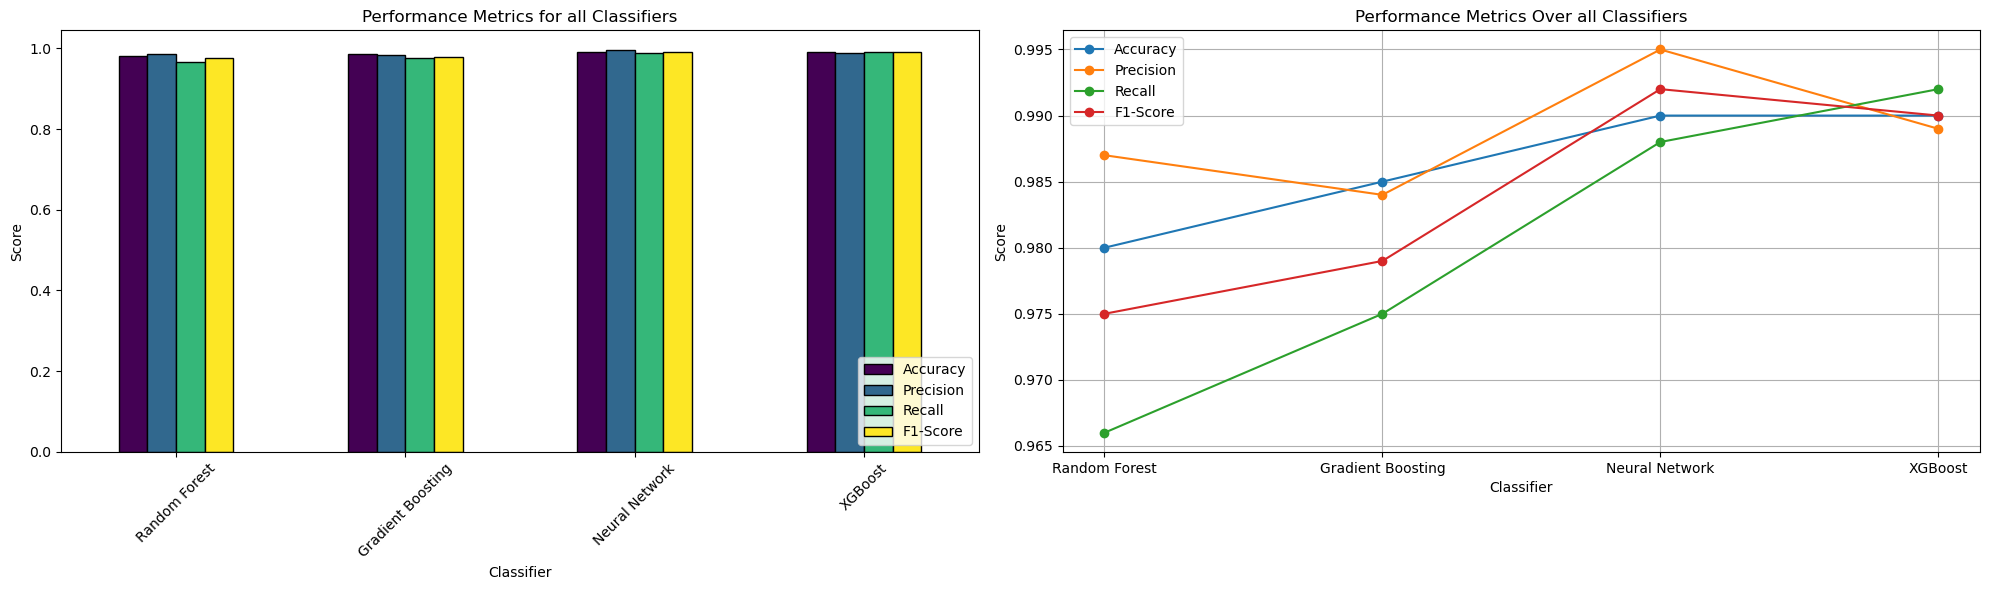

In [22]:
from tabulate import tabulate
data = {
    "Classifier": ["Random Forest", "Gradient Boosting", "Neural Network", "XGBoost"],
    "Accuracy": [rf_accuracy, gb_accuracy, nn_accuracy, xgb_accuracy],
    "Precision": [rf_precision, gb_precision, nn_precision, xgb_precision],
    "Recall": [rf_recall, gb_recall, nn_recall, xgb_recall],
    "F1-Score": [rf_fscore, gb_fscore, nn_fscore, xgb_fscore]
}

# Create a DataFrame
df = pd.DataFrame(data)
df = np.round(df, 3)
df.set_index('Classifier', inplace=True)

# Print the table
print(tabulate(df, headers='keys', tablefmt='pretty'))

# Create a figure with subplots for the bar chart and line chart
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bar chart for performance metrics
df.plot(kind='bar', colormap='viridis', edgecolor='black', ax=axes[0])
axes[0].set_title("Performance Metrics for all Classifiers")
axes[0].set_xlabel("Classifier")
axes[0].set_ylabel("Score")
axes[0].legend(loc='lower right')
axes[0].tick_params(axis='x', rotation=45)

# Line chart for performance metrics
for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    axes[1].plot(df.index, df[metric], marker='o', label=metric)

axes[1].set_title("Performance Metrics Over all Classifiers")
axes[1].set_xlabel("Classifier")
axes[1].set_ylabel("Score")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

<h1 align = 'center'>Models Training For UMAP(Uniform Manifold Approximation and Projection)</h1>


Uniform Manifold Approximation and Projection (UMAP) is a powerful dimension reduction technique that can be used for visualization, similar to t-SNE, as well as for general non-linear dimension reduction. Here's a simplified overview:

- **Assumptions**: UMAP is founded on three key assumptions about the data:
  1. The data is uniformly distributed on a Riemannian manifold.
  2. The Riemannian metric is locally constant or can be approximated as such.
  3. The manifold is locally connected.

- **Fuzzy Topological Structure**: Based on these assumptions, UMAP models the manifold with a fuzzy topological structure.

- **Algorithm**: The embedding in UMAP is found by searching for a low-dimensional projection of the data that closely preserves the equivalent fuzzy topological structure.

- **Installation**: You can install UMAP using either Conda or PyPI:
  - Conda: `conda install -c conda-forge umap-learn`
  - PyPI: `pip install umap-learn`

- **User Guide / Tutorial**: UMAP provides extensive documentation and tutorials on how to use it effectively for various tasks such as data visualization, dimensionality reduction, clustering, and more.

UMAP is widely used in diverse domains for tasks ranging from exploratory data analysis to machine learning and pattern recognition. It offers a flexible and efficient approach to reducing the dimensionality of complex datasets while preserving essential structures.


In [23]:
X = dataset
Y = labelset['Class']

# Split the dataset into training and testing sets with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize UMAP to reduce the data to 2 components
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Fit UMAP on the training data and transform both training and testing data
X_train_umap = umap_reducer.fit_transform(X_train)
X_test_umap = umap_reducer.transform(X_test)

# The shapes of the transformed data can be printed to verify the reduction
print(f"Original training data shape: {X_train.shape}")
print(f"Transformed training data shape: {X_train_umap.shape}")
print(f"Original testing data shape: {X_test.shape}")
print(f"Transformed testing data shape: {X_test_umap.shape}")


Original training data shape: (560, 20531)
Transformed training data shape: (560, 2)
Original testing data shape: (241, 20531)
Transformed testing data shape: (241, 2)


Random Forest Metrics For UMAP:
Accuracy: 100.00%
Precision (macro avg): 100.00%
Recall (macro avg): 100.00%
F1-score (macro avg): 100.00%

Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        90
        COAD       1.00      1.00      1.00        28
        KIRC       1.00      1.00      1.00        41
        LUAD       1.00      1.00      1.00        40
        PRAD       1.00      1.00      1.00        42

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



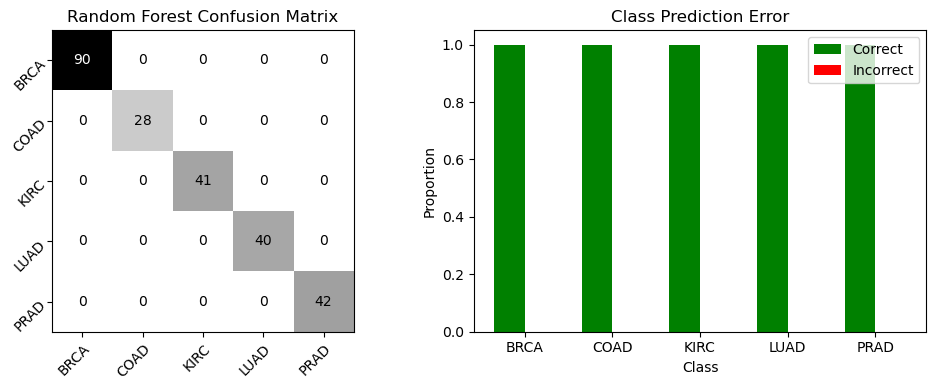

In [24]:
# Initialize the RandomForestClassifier with a random state for reproducibility for "UMAP"
rfc_clf = RandomForestClassifier(random_state=42)

# Fit the classifier on the PCA-transformed training data
rfc_clf.fit(X_train_umap, y_train)

# Predict on the PCA-transformed testing data
y_pred = rfc_clf.predict(X_test_umap)

# Define target names for the classification report
target_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average="macro")
rf_recall = recall_score(y_test, y_pred, average="macro")
rf_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"Random Forest Metrics For UMAP:")
print(f"Accuracy: {rf_accuracy*100:.2f}%")
print(f"Precision (macro avg): {rf_precision*100:.2f}%")
print(f"Recall (macro avg): {rf_recall*100:.2f}%")
print(f"F1-score (macro avg): {rf_fscore*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))



# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

XGBoost Classifier Metrics For UMAP:
Accuracy: 98.34%
Precision: 98.26%
Recall: 97.14%
F1-score: 97.55%

Classification Report:


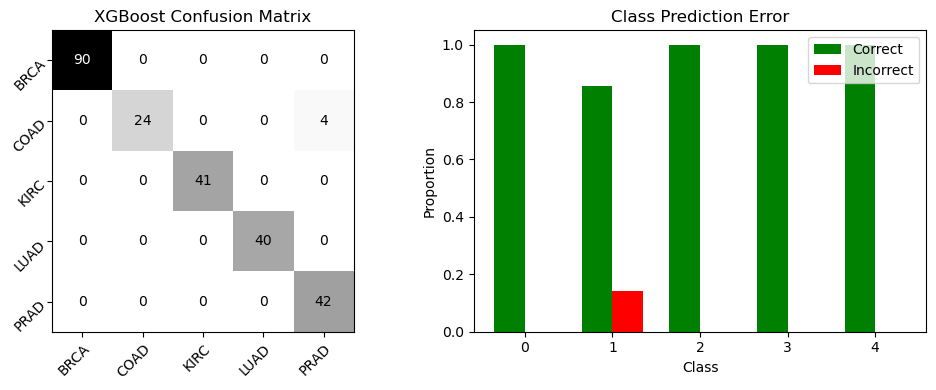

In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels and split the dataset
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Initialize and fit XGBoost classifier for UMAP
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=len(set(y_encoded)), seed=42)
xgb_clf.fit(X_train_umap, y_train)
y_pred = xgb_clf.predict(X_test_umap)

# Calculate and print metrics
xgb_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average="macro"),
    "Recall": recall_score(y_test, y_pred, average="macro"),
    "F1-score": f1_score(y_test, y_pred, average="macro")
}

print("XGBoost Classifier Metrics For UMAP:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value*100:.2f}%")

# Classification report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('XGBoost Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Neural Network Metrics:
Accuracy: 100.00%
Precision (macro avg): 100.00%
Recall (macro avg): 100.00%
F1-score (macro avg): 100.00%

Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        90
        COAD       1.00      1.00      1.00        28
        KIRC       1.00      1.00      1.00        41
        LUAD       1.00      1.00      1.00        40
        PRAD       1.00      1.00      1.00        42

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



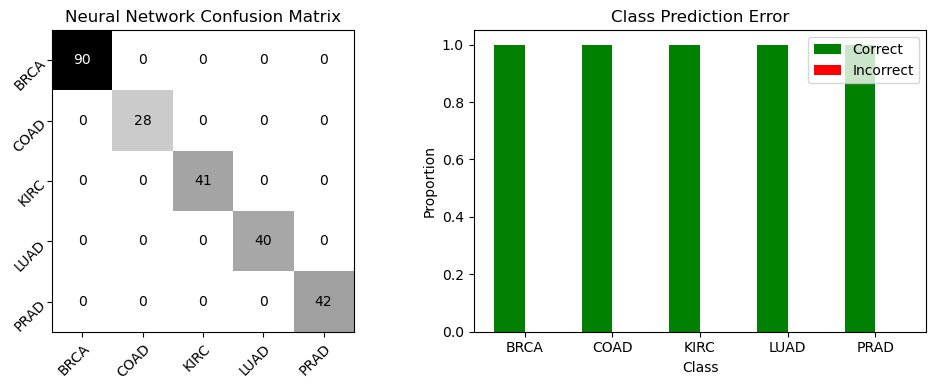

In [26]:
from sklearn.neural_network import MLPClassifier

# Initialize the Neural Network classifier with one hidden layer of 150 neurons
nn_clf = MLPClassifier(hidden_layer_sizes=(150,), max_iter=200, activation='relu', solver='adam', random_state=1)

# Train the model and predict on the test set
nn_clf.fit(X_train_umap, y_train)
y_pred = nn_clf.predict(X_test_umap)

# Define target names for the classes
target_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Calculate metrics
nn_accuracy = accuracy_score(y_test, y_pred)
nn_precision = precision_score(y_test, y_pred, average="macro")
nn_recall = recall_score(y_test, y_pred, average="macro")
nn_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"Neural Network Metrics:")
print(f"Accuracy: {nn_accuracy*100:.2f}%")
print(f"Precision (macro avg): {nn_precision*100:.2f}%")
print(f"Recall (macro avg): {nn_recall*100:.2f}%")
print(f"F1-score (macro avg): {nn_fscore*100:.2f}%")

# Generate and display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('Neural Network Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2, target_names)
# axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Gradient Boosting Metrics:
Accuracy: 100.00%
Precision (macro avg): 100.00%
Recall (macro avg): 100.00%
F1-score (macro avg): 100.00%

Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        90
        COAD       1.00      1.00      1.00        28
        KIRC       1.00      1.00      1.00        41
        LUAD       1.00      1.00      1.00        40
        PRAD       1.00      1.00      1.00        42

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



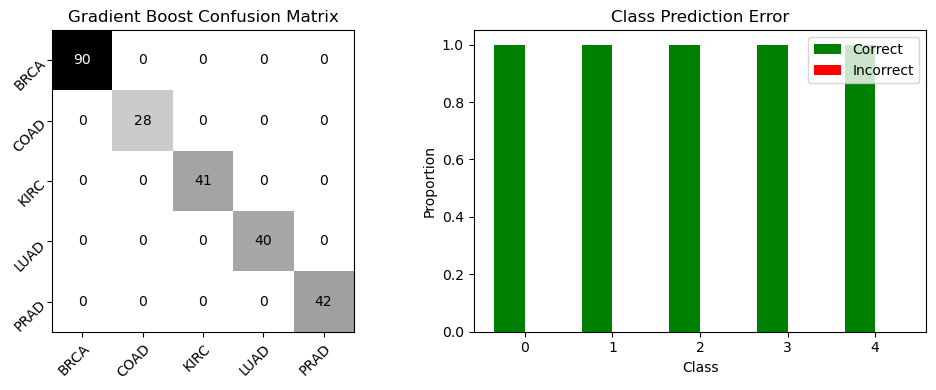

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier()

# Fit the model
gb_clf.fit(X_train_umap, y_train)
y_pred = gb_clf.predict(X_test_umap)

# Define target names for the classes
target_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Calculate metrics
gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred, average="macro")
gb_recall = recall_score(y_test, y_pred, average="macro")
gb_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"Gradient Boosting Metrics:")
print(f"Accuracy: {gb_accuracy*100:.2f}%")
print(f"Precision (macro avg): {gb_precision*100:.2f}%")
print(f"Recall (macro avg): {gb_recall*100:.2f}%")
print(f"F1-score (macro avg): {gb_fscore*100:.2f}%")

# Generate and display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('Gradient Boost Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(classes)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Support Vector Machines Metrics:
Accuracy: 100.00%
Precision (macro avg): 100.00%
Recall (macro avg): 100.00%
F1-score (macro avg): 100.00%

Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        90
        COAD       1.00      1.00      1.00        28
        KIRC       1.00      1.00      1.00        41
        LUAD       1.00      1.00      1.00        40
        PRAD       1.00      1.00      1.00        42

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



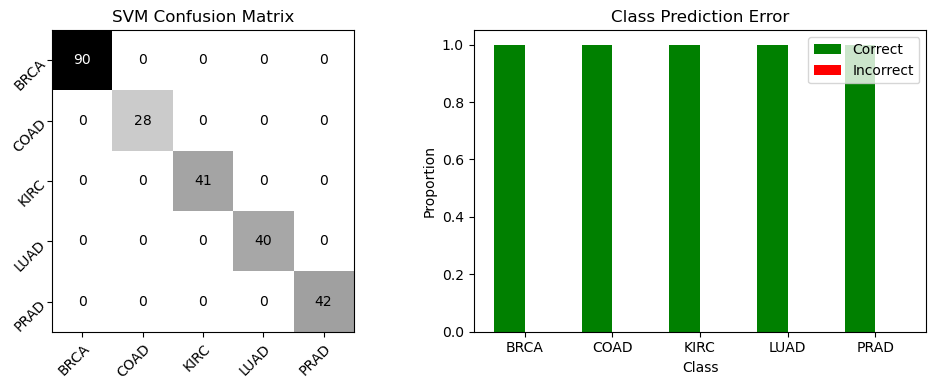

In [28]:
from sklearn.svm import SVC
# SVM Classifier
svm_clf = SVC()
svm_clf.fit(X_train_umap, y_train)
y_pred = svm_clf.predict(X_test_umap)

# Define target names
target_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']

# Calculate metrics
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred, average="macro")
svm_recall = recall_score(y_test, y_pred, average="macro")
svm_fscore = f1_score(y_test, y_pred, average="macro")

# Print metrics
print(f"Support Vector Machines Metrics:")
print(f"Accuracy: {svm_accuracy*100:.2f}%")
print(f"Precision (macro avg): {svm_precision*100:.2f}%")
print(f"Recall (macro avg): {svm_recall*100:.2f}%")
print(f"F1-score (macro avg): {svm_fscore*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = np.unique(y_test)

# Create a figure with subplots for the confusion matrix and class prediction error
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the confusion matrix on the first subplot
axes[0].imshow(conf_matrix, cmap=plt.cm.Greys)
axes[0].set_title('SVM Confusion Matrix')
axes[0].set_xticks(np.arange(len(target_names)))
axes[0].set_yticks(np.arange(len(target_names)))
axes[0].set_xticklabels(target_names)
axes[0].set_yticklabels(target_names)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[0].text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

# Plotting Class Prediction Error on the second subplot
class_totals = conf_matrix.sum(axis=1)
class_correct = np.diag(conf_matrix)
class_error = class_totals - class_correct
indices = np.arange(len(classes))
bar_width = 0.35
axes[1].bar(indices, class_correct / class_totals, bar_width, label='Correct', color='Green')
axes[1].bar(indices + bar_width, class_error / class_totals, bar_width, label='Incorrect', color='red')
axes[1].set_title('Class Prediction Error')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(indices + bar_width / 2)
axes[1].set_xticklabels(target_names)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

+-------------------+----------+-----------+--------+----------+
|    Classifier     | Accuracy | Precision | Recall | F1-Score |
+-------------------+----------+-----------+--------+----------+
|   Random Forest   |   1.0    |    1.0    |  1.0   |   1.0    |
|        SVM        |   1.0    |    1.0    |  1.0   |   1.0    |
| Gradiant Boosting |   1.0    |    1.0    |  1.0   |   1.0    |
|  Neural Network   |   1.0    |    1.0    |  1.0   |   1.0    |
|      XGBoost      |   0.99   |   0.989   | 0.992  |   0.99   |
+-------------------+----------+-----------+--------+----------+


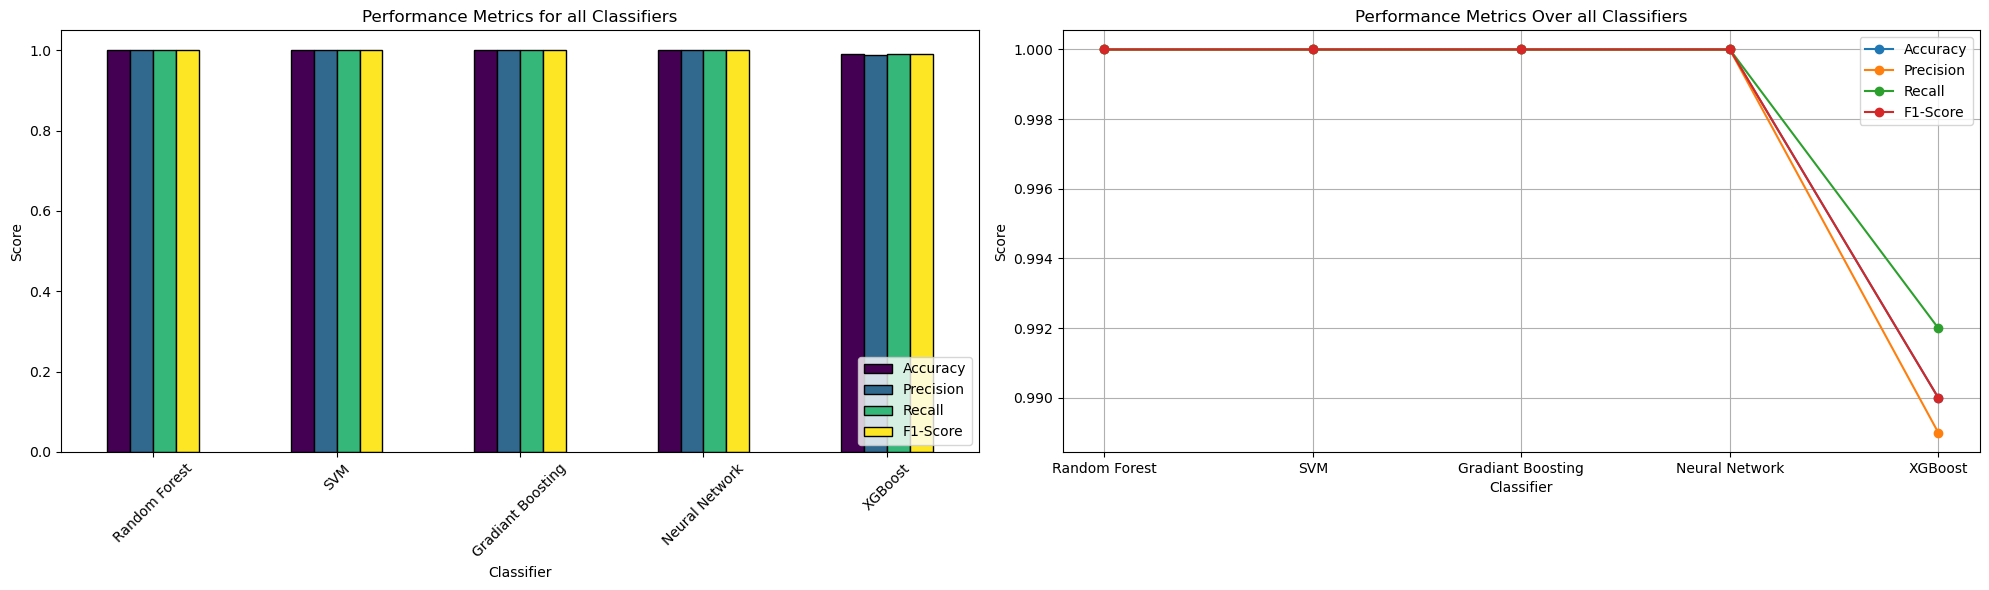

In [29]:
from tabulate import tabulate
data = {
    "Classifier": ["Random Forest", "SVM", "Gradiant Boosting", "Neural Network", "XGBoost"],
    "Accuracy": [rf_accuracy, svm_accuracy, gb_accuracy, nn_accuracy, xgb_accuracy],
    "Precision": [rf_precision, svm_precision, gb_precision, nn_precision, xgb_precision],
    "Recall": [rf_recall, svm_recall, gb_recall, nn_recall, xgb_recall],
    "F1-Score": [rf_fscore, svm_fscore, gb_fscore, nn_fscore, xgb_fscore]
}

# Create a DataFrame
df = pd.DataFrame(data)
df = np.round(df, 3)
df.set_index('Classifier', inplace=True)

# Print the table
print(tabulate(df, headers='keys', tablefmt='pretty'))

# Create a figure with subplots for the bar chart and line chart
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bar chart for performance metrics
df.plot(kind='bar', colormap='viridis', edgecolor='black', ax=axes[0])
axes[0].set_title("Performance Metrics for all Classifiers")
axes[0].set_xlabel("Classifier")
axes[0].set_ylabel("Score")
axes[0].legend(loc='lower right')
axes[0].tick_params(axis='x', rotation=45)

# Line chart for performance metrics
for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    axes[1].plot(df.index, df[metric], marker='o', label=metric)

axes[1].set_title("Performance Metrics Over all Classifiers")
axes[1].set_xlabel("Classifier")
axes[1].set_ylabel("Score")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()